In [82]:
import torch
import sys

sys.path.append("../")
from RNN_Class import *
import matplotlib.pyplot as plt
import glob

Code originally from Figure4.py

In [42]:
N, SeqN, HN = 100, 100, 100
RecordN = 2000

## Load input data

In [43]:
# load input data
data_path = f"../data/Ns{N}_SeqN{SeqN}/"
data_name = "Ns{}_SeqN{}_1".format(N, SeqN)
data = torch.load(data_path + data_name + ".pth.tar")
X_mini = data["X_mini"][:, :-1, :]
Target_mini = data["Target_mini"][:, 1:, :]

print("X_mini shape", X_mini.shape)
print("Target_mini shape:", Target_mini.shape)

X_mini shape torch.Size([1, 99, 100])
Target_mini shape: torch.Size([1, 99, 100])


### Env 1

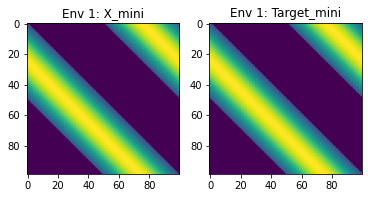

In [44]:
fig, axes = plt.subplots(1, 2)

axes[0].imshow(X_mini[0, :, :])
axes[0].set_title("Env 1: X_mini")

axes[1].imshow(Target_mini[0, :, :])
axes[1].set_title("Env 1: Target_mini")
plt.show()

### Noisy version of Env 1

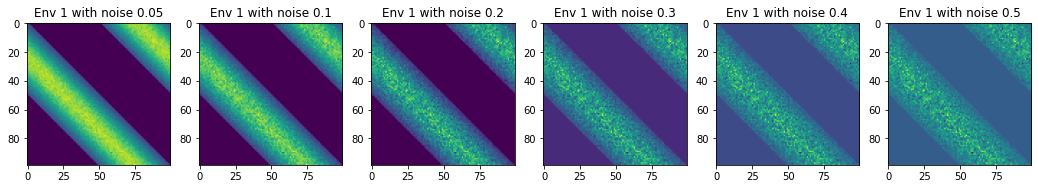

In [45]:
# Save a noisy version of env 1
# Independent random gaussian noise N~(0,activity*noise_level)
# noise level range from 0.05 to 0.5
noise_levels = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
noisy_data_name = f"Ns{N}_SeqN{SeqN}_1_"

fig, axes = plt.subplots(1, 6, figsize=(18, 3))

for i, ax in enumerate(axes, start=1):
    path = (
        data_path
        + noisy_data_name
        + str(int(100 * noise_levels[i - 1]))
        + "per.pth.tar"
    )
    data = torch.load(path)
    X_mini = data["X_mini"][:, :-1, :]
    ax.imshow(X_mini[0, :, :])
    ax.set_title(f"Env 1 with noise {noise_levels[i - 1]}")
plt.show()

### Env 2

In [47]:
# load input data
data_path = f"../data/Ns{N}_SeqN{SeqN}/"
data_name = "Ns{}_SeqN{}_2".format(N, SeqN)
data = torch.load(data_path + data_name + ".pth.tar")
X_mini = data["X_mini"][:, :-1, :]
Target_mini = data["Target_mini"][:, 1:, :]

print("X_mini shape", X_mini.shape)
print("Target_mini shape:", Target_mini.shape)

X_mini shape torch.Size([1, 99, 100])
Target_mini shape: torch.Size([1, 99, 100])


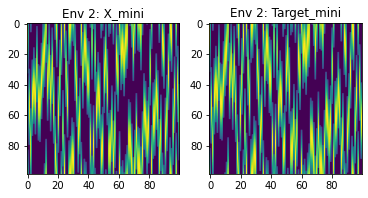

In [48]:
fig, axes = plt.subplots(1, 2)

axes[0].imshow(X_mini[0, :, :])
axes[0].set_title("Env 2: X_mini")

axes[1].imshow(Target_mini[0, :, :])
axes[1].set_title("Env 2: Target_mini")
plt.show()

# Panel B: Replay

In [49]:
model_path = "../Elman_SGD/Remap_predloss/N100T100/"
N, SeqN, HN = 100, 100, 100
RecordN = 2000
data_name = "Ns{}_SeqN{}_1".format(N, SeqN)
model_name = "Ns{}_SeqN{}_predloss_full".format(N, SeqN)
model = ElmanRNN_tp1(N, HN, N)
model.act = nn.Sigmoid()
model_remap = ElmanRNN_tp1(N, HN, N)
model_remap.act = nn.Sigmoid()
net = torch.load(model_path + model_name + ".pth.tar", map_location="cuda:0")
data = torch.load(data_path + data_name + ".pth.tar")
model.load_state_dict(net["state_dict"])
X_mini = data["X_mini"][:, :-1, :]
Target_mini = data["Target_mini"][:, 1:, :]
output_previous, _ = model(X_mini, torch.zeros((1, 1, HN)))

In [69]:
SeqN = 100
N = 100
HN = 100
X_noise = np.random.normal(0, 1, X_mini.shape) * X_mini.numpy().max() * 0.01
X_noise = torch.tensor(X_noise.astype(np.single))
output_null, _ = model(X_noise, torch.zeros((1, 1, HN)))
Target_p = Target_mini[0, :, :].T
output_p = output_null.detach().numpy()[0, :, :].T
title_list = [
    "Input current ($x_t$)",
    "Target output ($y_t$)",
    "Output after training ($\hat{y_t}$)",
]
vmax_list = np.array([X_noise.max(), Target_p.max(), output_p.max()])

Replay: given low magnitude random input simulating spontaneous activities, 
a predictive recurrent autoencoder outputs its previously remembered pattern
vmax_list [0.03576095 1.         0.9423056 ]


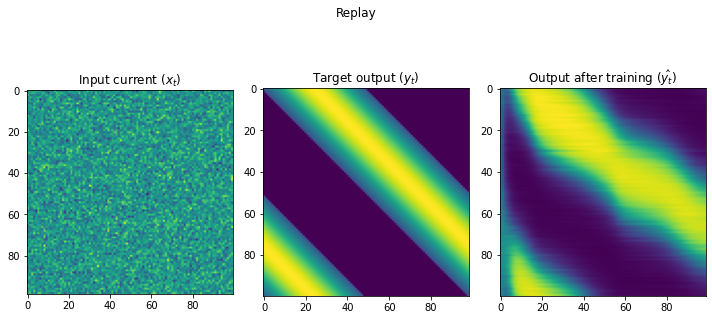

In [71]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
data = [X_noise[0, :, :], Target_p, output_p]

for i in range(3):
    axes[i].imshow(data[i])
    axes[i].set_title(title_list[i])

plt.suptitle("Replay")
plt.tight_layout()

print(
    "Replay: given low magnitude random input simulating spontaneous activities, \na predictive recurrent autoencoder outputs its previously remembered pattern"
)
print("vmax_list", vmax_list)
plt.show()

# Panel B: Prediction

In [72]:
X_noise[:, :10, :] = X_mini[:, :10, :]
output_null, _ = model(X_noise, torch.zeros((1, 1, HN)))
output_p = output_null.detach().numpy()[0, :, :].T
title_list = [
    "Input current ($x_t$)",
    "Target output ($y_t$)",
    "Output after training ($\hat{y_t}$)",
]
vmax_list = np.array([X_noise.max(), Target_p.max(), output_p.max()])

Prediction: given input of the first 10 time steps, 
the network performed pattern completion
vmax_list [1.        1.        0.9424448]


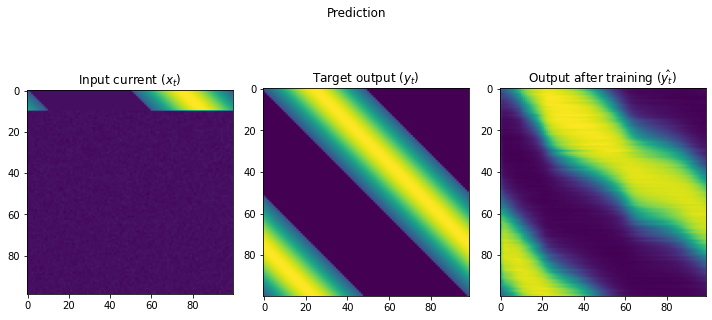

In [74]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
data = [X_noise[0, :, :], Target_p, output_p]

for i in range(3):
    axes[i].imshow(data[i])
    axes[i].set_title(title_list[i])

plt.suptitle("Prediction")
plt.tight_layout()

print(
    "Prediction: given input of the first 10 time steps, \nthe network performed pattern completion"
)
print("vmax_list", vmax_list)
plt.show()

# Panel C: Weight trace

In [75]:
model_name = "Ns{}_SeqN{}_2Batch_predloss".format(N, SeqN)
data_name = "Ns{}_SeqN{}_2Batch".format(N, SeqN)
model = ElmanRNN_tp1(N, HN, N)
model.act = nn.Sigmoid()
net = torch.load(model_path + model_name + ".pth.tar")
data = torch.load(data_path + data_name + ".pth.tar")
X_mini = data["X_mini"][:, :-1, :]
model.load_state_dict(net["state_dict"])
W = net["state_dict"]["hidden_linear.weight"].cpu().numpy()

In [77]:
# build hidden weights
hidden = np.zeros((HN, SeqN - 1))
hidden_new = np.zeros((HN, SeqN - 1))
output = np.zeros((N, SeqN - 1))
output_new = np.zeros((N, SeqN - 1))
h = torch.zeros(1, 1, HN)
for t in np.arange(SeqN - 1):
    o, h = model(X_mini[0:1, t : t + 1, :], h)
    hidden[:, t] = h.detach().numpy()[0, 0, :]
    output[:, t] = o.detach().numpy()[0, 0, :]
h = torch.zeros(1, 1, HN)
for t in np.arange(SeqN - 1):
    o, h = model(X_mini[1:2, t : t + 1, :], h)
    hidden_new[:, t] = h.detach().numpy()[0, 0, :]
    output_new[:, t] = o.detach().numpy()[0, 0, :]

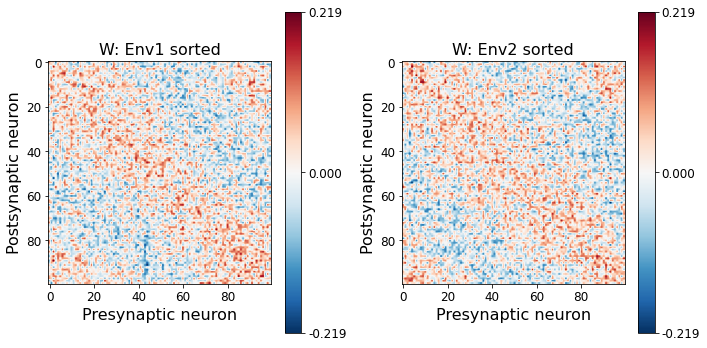

In [79]:
hidden_pool = [hidden, hidden_new]
idx = []
c_max = np.abs(W).max()
plt.figure(figsize=(10, 5))
for i in range(2):
    idx.append(np.argsort(np.argmax(hidden_pool[i], axis=1)))
    plt.subplot(1, 2, i + 1)
    plt.imshow(
        W[idx[i], :][:, idx[i]], cmap="RdBu_r", vmin=-1.001 * c_max, vmax=1.001 * c_max
    )
    crange = [-c_max, 0, c_max]
    cbar = plt.colorbar(ticks=crange)
    cbar.ax.set_yticklabels(["{:.3f}".format(item) for item in crange])
    plt.xlabel("Presynaptic neuron")
    plt.ylabel("Postsynaptic neuron")
    plt.title("W: Env{} sorted".format(i + 1))
    plt.rc("font", size=12)
    plt.rc("axes", titlesize=16, labelsize=16)

plt.tight_layout()
plt.show()

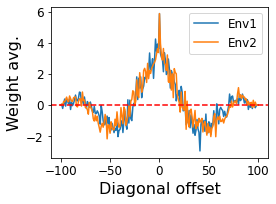

In [81]:
offset_list = np.arange(-N, N + 1)
plt.figure(figsize=(4, 3))
for i in np.arange(2):
    plt_idx = np.argsort(np.argmax(hidden_pool[i], axis=1))
    trace_list = np.array(
        [np.trace(W[plt_idx, :][:, plt_idx], offset=i) for i in offset_list]
    )
    plt.plot(offset_list, trace_list)
    plt.xlabel("Diagonal offset")
    plt.ylabel("Weight avg.")
    plt.rc("font", size=12)
    plt.rc("axes", titlesize=16, labelsize=16)

plt.axhline(y=0, color="r", linestyle="--")
plt.tight_layout()
plt.legend(["Env{}".format(i + 1) for i in np.arange(2)])
plt.show()

# Panel D: CA1 vs CA3 place fields

In [87]:
### concatenate training stages
novel = 1  # for F -> N remapping
# novel = 0 # for F -> F remapping
Path = "../Elman_SGD/Remap_predloss/"
N, SeqN = 100, 100
HN = 100
if novel:
    noise_level_list = [0.0001]
else:
    noise_level_list = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]

for noise_level in noise_level_list:
    env1_name = "Ns{}_SeqN{}_1".format(N, SeqN)
    if novel:
        env2_name = "Ns{}_SeqN{}_2".format(N, SeqN)
        subpath = "N{}T{}_relu_fixio/stages/".format(N, SeqN)
    else:
        env2_name = "Ns{}_SeqN{}_1_{}per".format(N, SeqN, int(noise_level * 100))
        subpath = "N{}T{}_relu_fixio/F{}per_stages/".format(
            N, SeqN, int(noise_level * 100)
        )
    print(subpath)
    model0_name = "N{}T{}_relu_fixio/pred_relu".format(N, SeqN)
    net = ElmanRNN_pytorch_module_v2(N, HN, N)
    net.act = nn.Sigmoid()
    net.rnn = nn.RNN(N, HN, 1, batch_first=True, nonlinearity="relu")
    # Before exposure to env2
    env1 = torch.load(data_path + env1_name + ".pth.tar")
    X_mini = env1["X_mini"][:, :-1, :]
    env2 = torch.load(data_path + env2_name + ".pth.tar")
    X_new = env2["X_mini"][:, :-1, :]
    model0 = torch.load(Path + model0_name + ".pth.tar", map_location="cuda:0")
    net.load_state_dict(model0["state_dict"])
    output_old, h_seq_old = net(X_mini, torch.zeros((1, 1, HN)))
    output0, h_seq0 = net(X_new, torch.zeros((1, 1, HN)))
    y_hat = np.zeros((1, SeqN - 1, N))
    hidden = np.zeros((1, SeqN - 1, HN))
    y_hat[0, :, :] = output_old.detach().numpy()[0, :, :]
    hidden[0, :, :] = h_seq_old.detach().numpy()[0, :, :]
    epoch, epoch_list = 0, [0]
    previous_ep = 0
    remaps = glob.glob(Path + subpath + "remap_s*.pth.tar")
    for i, remap_name in enumerate(remaps):
        remap = torch.load(remap_name)
        y_hat = np.concatenate((y_hat, remap["y_hat"][:, 0, :, :]), axis=0)
        hidden = np.concatenate((hidden, remap["hidden"][:, 0, :, :]), axis=0)
        epoch_list += [
            i + previous_ep
            for i in range(
                0,
                len(remap["loss"]),
                int(len(remap["loss"]) / remap["hidden"].shape[0]),
            )
        ]
        previous_ep += len(remap["loss"])
    torch.save(
        {
            "X_mini": X_mini,
            "X_new": X_new,
            "y_hat": y_hat,
            "hidden": hidden,
            "epoch_list": epoch_list,
        },
        Path + subpath + "HO_evol.pth.tar",
    )

N100T100_relu_fixio/stages/


In [88]:
### generate CA1 and CA3 responses
for noise_level in noise_level_list:
    if novel:
        subpath = "N100T100_relu_fixio/stages/"
    else:
        subpath = "N100T100_relu_fixio/F{}per_stages/".format(int(noise_level * 100))
    loaded = torch.load(Path + subpath + "HO_evol.pth.tar")
    X_mini = loaded["X_mini"]
    X_new = loaded["X_new"]
    y_hat = loaded["y_hat"]
    hidden = loaded["hidden"]
    epoch_list = loaded["epoch_list"]
    err_list = []
    for i in range(len(epoch_list)):
        if i == 0:
            err = X_mini.numpy()[0, :, :] - y_hat[i, :, :]
        else:
            err = X_new.numpy()[0, :, :] - y_hat[i, :, :]
        err = 1 / 2 * (err + np.abs(err))
        err_list.append(err.mean())
    print(err_list)
    err_matrix = np.zeros(y_hat.shape)
    for i in range(y_hat.shape[0]):
        if i == 0:
            continue
        tmp = X_new.numpy()[0, :, :] - y_hat[i, :, :]
        err_matrix[i, :] = (np.abs(tmp) + tmp) / 2
    CA1_rep = np.concatenate((y_hat, err_matrix), axis=2)
    CA3_rep = hidden
    torch.save(
        {"CA1_rep": CA1_rep, "CA3_rep": CA3_rep}, Path + subpath + "Field2_evol.pth.tar"
    )

[0.0626536822268915, 0.14937238253878823, 0.14648509396296558, 0.14539705682734047, 0.1466741143392794, 0.14674458634672743, 0.14630266029274824, 0.1485419572603823, 0.14725164705003152, 0.1467802631945321, 0.14659001073903508, 0.14723723002154418, 0.1477686368049395, 0.14659791946110098, 0.1460206435139131, 0.14550011781430003, 0.14505411747429106, 0.1439585120238439, 0.14315784736263631, 0.14224721619351344, 0.14159653269657582, 0.11838204101066697, 0.10661634552979259, 0.10081232907984293, 0.09641105065094024, 0.09345071514141058, 0.08763433826688463, 0.08381795491283464, 0.08215162240255898, 0.0812113775434924, 0.0807884548442175]


# Panel D: plot fields in F and N after stabilized